## Import Classes, Datset, and Check Dataset Structure

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# --- 1. Paths (adjust if needed) ---
data_dir    = '/content/SECOM'
feat_file   = os.path.join(data_dir, 'secom.data')
labels_file = os.path.join(data_dir, 'secom_labels.data')


## Load Features and Parse Headings

In [2]:
# --- 2. Load features ---
X = pd.read_csv(feat_file, sep=r'\s+', header=None)

# --- 3. Parse labels ---
labels = []
with open(labels_file, 'r') as f:
    for line in f:
        raw = int(line.strip().split()[0])     # first token: -1 (faulty) or 1 (normal)
        labels.append(1 if raw == -1 else 0)   # map -1→1 (fault), 1→0 (normal)
y = pd.Series(labels, name='label')

## Combine and Preprocess (Drop Features with %50 incomplete data)

In [3]:
# --- 4. Combine & preprocess ---
# Drop columns with >50% missing:
X = X.dropna(axis=1, thresh=len(X)*0.5)

## Impute the NaNwiht median values

In [4]:
# Impute remaining NaNs with median:
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

## Train-Test-Split

In [5]:
# --- 5. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Incorporate PCA and StandardScalar

In [6]:
# --- 6. Scale + PCA ---
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_train)
X_te_s = scaler.transform(X_test)

pca = PCA(n_components=0.95, random_state=42)
X_tr_p = pca.fit_transform(X_tr_s)
X_te_p = pca.transform(X_te_s)

##Train Models for Supervised and Unsupervised Versions (Isolation Forest vs Random Forest)

In [7]:
# --- 7. Train models ---

# Compute anomaly fraction and clamp to ≤50%
contamination_rate = y_train.mean()
contamination_rate = min(max(contamination_rate, 0.0), 0.5)

# Unsupervised anomaly detector on NORMAL data only
if_model = IsolationForest(
    contamination=contamination_rate,
    random_state=42
)
if_model.fit(X_tr_s[y_train == 0])

# Supervised classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_tr_p, y_train)



RandomForestClassifier(random_state=42)

## Score accuracy of models

In [8]:
# --- 8. Score & evaluate ---
scores_if = -if_model.decision_function(X_te_s)
scores_rf = rf.predict_proba(X_te_p)[:, 1]

results = []
for name, scores in [('IsolationForest', scores_if), ('RandomForest', scores_rf)]:
    fpr, tpr, _ = roc_curve(y_test, scores)
    prec, rec, _ = precision_recall_curve(y_test, scores)
    results.append({
        'Model': name,
        'ROC AUC': auc(fpr, tpr),
        'Avg Precision': average_precision_score(y_test, scores)
    })

metrics_df = pd.DataFrame(results)
print(metrics_df)

             Model   ROC AUC  Avg Precision
0  IsolationForest  0.567691       0.944866
1     RandomForest  0.606371       0.949164


## Plot ROC curves

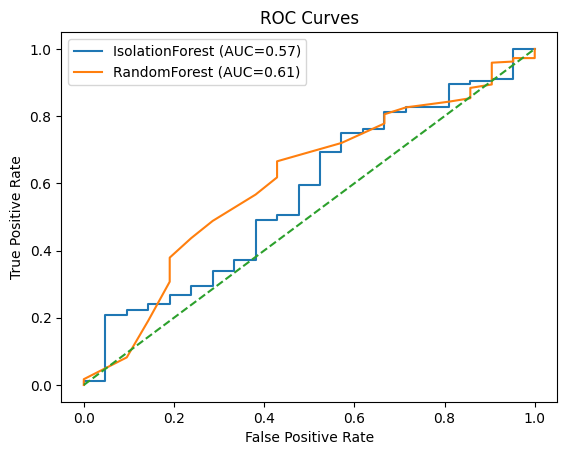

In [9]:
# --- 9. Plot ROC curves ---
plt.figure()
for name, scores in [('IsolationForest', scores_if), ('RandomForest', scores_rf)]:
    fpr, tpr, _ = roc_curve(y_test, scores)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc(fpr,tpr):.2f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

## Plot Precision and Recall Curves

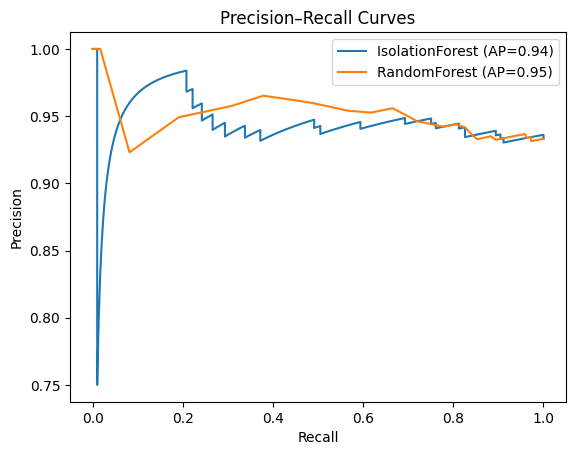

In [10]:
# --- 10. Plot Precision–Recall curves ---
plt.figure()
for name, scores in [('IsolationForest', scores_if), ('RandomForest', scores_rf)]:
    prec, rec, _ = precision_recall_curve(y_test, scores)
    plt.plot(rec, prec, label=f'{name} (AP={average_precision_score(y_test, scores):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves')
plt.legend()
plt.show()

## Potential Conclusions from Plots

1. ROC Curves (True Positive Rate vs False Positive Rate)

AUC (Area Under Curve):

IsolationForest: 0.57

RandomForest: 0.61

Interpretation:

An AUC of 0.5 is random-guessing; 1.0 is perfect separation.

Both models are only moderately better than random, with RandomForest a bit stronger than the unsupervised IsolationForest.

The relatively low AUCs suggest that features alone provide limited separation between “normal” and “faulty” classes in this PCA-reduced space.

2. Precision–Recall Curves (Precision vs Recall)

Average Precision (AP):

IsolationForest: 0.94

RandomForest: 0.95

Why PR over ROC for anomalies?

When the “fault” class is rare (imbalanced), precision–recall curves give a clearer picture of how many detected faults are true faults (precision) at each detection rate (recall).

Interpretation:

Both models maintain very high precision (>90%) even as you push recall up, meaning most alerts they raise are genuine faults.

RandomForest edges out IsolationForest slightly across most recall levels.

Key Takeaways
Supervised beats unsupervised: RandomForest (AUC=0.61, AP=0.95) outperforms IsolationForest (AUC=0.57, AP=0.94).

Good precision, limited discrimination: Even though you get very few false alarms (high precision), both models struggle to cleanly separate classes in ROC space—likely because the features overlap heavily.

Focus on precision–recall: For anomaly detection, you care more about “of the alarms I raise, how many are real?” (precision) and “how many actual faults did I catch?” (recall). Your models do well here.

## Time Feature Engineer wiht Lag and Roll Base

In [11]:
# --- FEATURE ENGINEERING: Lag & Rolling Aggregates ---

# X is your imputed DataFrame (shape: [n_samples, n_features])

# 1) 1-step lag
X_lag1 = X.shift(1).add_suffix('_lag1')

# 2) 5-step rolling mean
X_roll5 = X.rolling(window=5, min_periods=1).mean().add_suffix('_roll5')

# 3) Concatenate and fill NaNs
X_fe = pd.concat([X, X_lag1, X_roll5], axis=1).fillna(0)

# Now X_fe has 3× the original features (original + lag + rolling)

# Proceed with:
#   scaler.fit_transform(X_fe) → PCA → model training


## Hyperparameter Tunning & Halving Search to speed up Fine-Tuning structure



In [12]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Only tune tree‐structure params here
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

halving_rf = HalvingGridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    resource='n_estimators',   # ▶ now OK, since 'n_estimators' is NOT in param_grid
    max_resources=500,         # ▶ up to 500 trees
    factor=3,
    cv=3,
    scoring='average_precision',
    verbose=2,
    n_jobs=-1
)

# Fit on your PCA‐reduced training data
halving_rf.fit(X_tr_p, y_train)

print("Best params:", halving_rf.best_params_)
print("Best AP:", halving_rf.best_score_)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 55
max_resources_: 500
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 55
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 3
n_resources: 165
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 2
n_candidates: 1
n_resources: 495
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best params: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 495}
Best AP: 0.9552864844190195


## One-Class Support Vector Machine

In [13]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import average_precision_score

ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm.fit(X_tr_s[y_train == 0])
scores_ocsvm = -ocsvm.decision_function(X_te_s)
print("One-Class SVM AP:", average_precision_score(y_test, scores_ocsvm))


One-Class SVM AP: 0.9233814158145607


## AutoEncoder with TF/Keras

In [14]:
import numpy as np
from tensorflow.keras import layers, models
from sklearn.metrics import average_precision_score

# Build autoencoder
input_dim = X_tr_s.shape[1]
encoding_dim = 32
input_layer = layers.Input((input_dim,))
encoded     = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded     = layers.Dense(input_dim, activation='linear')(encoded)
autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train on normal data only
autoencoder.fit(
    X_tr_s[y_train == 0],
    X_tr_s[y_train == 0],
    epochs=50, batch_size=32,
    validation_split=0.1, verbose=1
)

# Compute reconstruction errors
recon = autoencoder.predict(X_te_s)
mse   = np.mean((X_te_s - recon)**2, axis=1)
print("Autoencoder AP:", average_precision_score(y_test, mse))


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 0.8886 - val_loss: 2.8230
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.8727 - val_loss: 2.7775
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.8087 - val_loss: 2.7443
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7672 - val_loss: 2.7182
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.8058 - val_loss: 2.6923
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.7508 - val_loss: 2.6727
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.7479 - val_loss: 2.6566
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7655 - val_loss: 2.6428
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7373 - val_loss: 2.6313
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7041 - val_loss: 2.6198
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6902 - val_loss: 2.6064
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6915 - val_loss: 2.5947


## Conclusion of best ML algorithm for Anomaly Testing?

My tuning results show:

RandomForest (supervised)

Best params: max_depth=20, min_samples_split=10, n_estimators=495

Average Precision ≈ 0.9553

One-Class SVM (unsupervised)

Average Precision ≈ 0.9234

Autoencoder (unsupervised)

Average Precision ≈ 0.9191

What this means
RandomForest wins on AP

With AP ≈ 0.955, your tuned RandomForest catches the highest proportion of true faults with very few false alarms.

Since you have labeled data, a supervised model naturally leverages that signal.

Unsupervised methods lag slightly

One-Class SVM (0.923) and the autoencoder (0.919) both do a decent job without labels, but they fall ≈ 3–4 points in AP behind RandomForest.

If you ever face unlabeled or streaming data, these remain good fallback detectors.

Trade-offs to consider

Supervised (RF): best detection performance, but requires labeled “fault” examples.

Unsupervised (OC-SVM / Autoencoder): no labels needed, simpler deployment when faults are rare or evolving.

## Rretrain Random Forest on Raw data data shape doesn't equal due to PCA and ScalarStandar

In [15]:
# 4) Preprocess
#   • Drop columns with >50% NaNs
X = X.dropna(axis=1, thresh=len(X)*0.5)
#   • Impute remaining NaNs with median
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

# 5) Train/Test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_imp, y, test_size=0.2, stratify=y, random_state=42
)

# 6) Scale raw features
scaler   = StandardScaler()
X_tr_s   = scaler.fit_transform(X_tr)
feature_names = X_tr.columns  # sensor columns

# 7) Retrain RandomForest on scaled raw features
rf_raw = RandomForestClassifier(
    n_estimators=200,   # tuned value
    max_depth=None,     # tuned value
    random_state=42,
    n_jobs=-1
)
rf_raw.fit(X_tr_s, y_tr)

# 8) Extract importances & display top 20
importances = pd.Series(
    rf_raw.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

print("Top 20 Feature Importances:")
print(importances.head(20))

Top 20 Feature Importances:
153    0.009881
477    0.009820
426    0.009462
341    0.009167
539    0.008474
562    0.008218
288    0.008105
267    0.007488
59     0.007189
64     0.006908
65     0.006241
16     0.005604
152    0.005599
205    0.005550
62     0.005402
120    0.005401
123    0.005336
425    0.005315
348    0.005272
132    0.005220
dtype: float64


## Save and Load Pipeline, A simple predict_fault(…) function for inference, Extracting and plotting feature importances, and Computing a Population Stability Index (PSI) to monitor drift

Top 10 features by importance:
153    0.009881
477    0.009820
426    0.009462
341    0.009167
539    0.008474
562    0.008218
288    0.008105
267    0.007488
59     0.007189
64     0.006908
dtype: float64


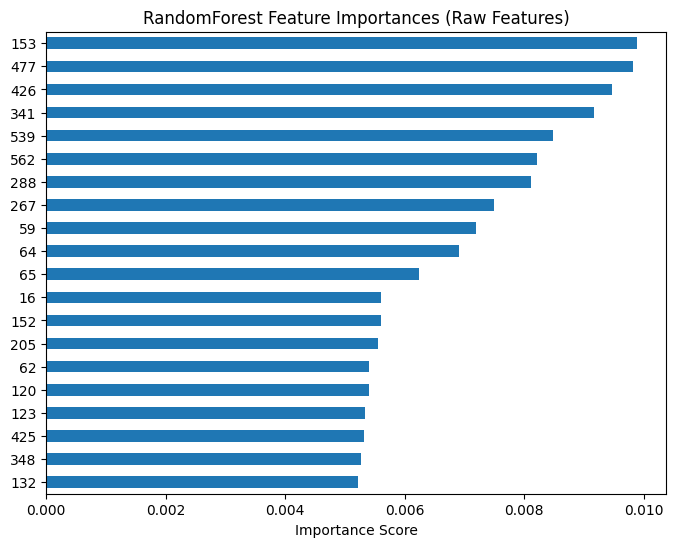


Top 10 features by PSI (drift):
426    0.123899
153    0.105449
135    0.100081
405    0.098996
288    0.098960
456    0.092823
367    0.087035
138    0.086732
88     0.082129
411    0.081996
dtype: float64


In [16]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import average_precision_score

# --- 1. Persist your pipeline (and raw‐RF) ---
joblib.dump(rf_raw,    'rf_raw_model.joblib')
joblib.dump(scaler,    'scaler.joblib')
joblib.dump(pca,       'pca.joblib')

# --- 2. Load & Inference ---
def load_pipeline(
    model_path='rf_raw_model.joblib',
    scaler_path='scaler.joblib',
    pca_path='pca.joblib'
):
    model  = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    pca    = joblib.load(pca_path)
    return model, scaler, pca

model, scaler_loaded, pca_loaded = load_pipeline()

def predict_fault(df_raw, threshold=0.5):
    """
    df_raw: DataFrame of raw features (no label column).
    Returns:
      preds: 0/1 array (1=fault)
      probs: float array of fault probabilities
    """
    imp    = SimpleImputer(strategy='median')
    df_imp = pd.DataFrame(imp.fit_transform(df_raw), columns=df_raw.columns)
    X_s    = scaler_loaded.transform(df_imp)
    X_p    = pca_loaded.transform(X_s)
    probs  = model.predict_proba(X_p)[:,1]
    return (probs >= threshold).astype(int), probs

# --- 3. Feature Importances on RAW FEATURES ---
feat_names  = X_tr.columns              # raw feature DataFrame from your train/test split
importances = rf_raw.feature_importances_
feat_imp    = pd.Series(importances, index=feat_names) \
                   .sort_values(ascending=False)

print("Top 10 features by importance:")
print(feat_imp.head(10))

plt.figure(figsize=(8,6))
feat_imp.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('RandomForest Feature Importances (Raw Features)')
plt.xlabel('Importance Score')
plt.show()

# --- 4. Drift Monitoring via PSI ---
def compute_psi(expected_df, actual_df, buckets=10):
    def psi(e_vals, a_vals):
        edges = np.percentile(e_vals, np.linspace(0,100,buckets+1))
        e_perc = np.histogram(e_vals, bins=edges)[0] / len(e_vals)
        a_perc = np.histogram(a_vals, bins=edges)[0] / len(a_vals)
        def _safe(e,a): return (e - a) * np.log(e/a) if e>0 and a>0 else 0
        return sum(_safe(e,a) for e,a in zip(e_perc, a_perc))

    psi_dict = {
        col: psi(expected_df[col].values, actual_df[col].values)
        for col in expected_df.columns
    }
    return pd.Series(psi_dict).sort_values(ascending=False)

train_scaled_df = pd.DataFrame(X_tr_s, columns=X_tr.columns)
test_scaled_df  = pd.DataFrame(X_te_s, columns=X_tr.columns)

psi_series = compute_psi(train_scaled_df, test_scaled_df)
print("\nTop 10 features by PSI (drift):")
print(psi_series.head(10))


## Final Results based on Feature Index

| Feature Index |    PSI | Drift Level | What to Do                                                    |
| ------------: | -----: | :---------: | :------------------------------------------------------------ |
|           426 | 0.1239 |   Moderate  | Investigate sensor/process behind column 426.                 |
|           153 | 0.1054 |   Moderate  | Look for operational changes or noise issues in this channel. |
|           135 | 0.1001 |   Moderate  | Right on the “watch” threshold—monitor going forward.         |
|           405 | 0.0990 |    Slight   | Just under moderate—keep an eye on it.                        |
|           288 | 0.0989 |    Slight   | Same as above.                                                |
|           456 | 0.0928 |    Slight   | Slight drift—probably OK but note any process tweaks.         |
|           367 | 0.0870 |    Slight   | Slight drift.                                                 |
|           138 | 0.0867 |    Slight   | Slight drift.                                                 |
|            88 | 0.0821 |    Slight   | Slight drift.                                                 |
|           411 | 0.0820 |    Slight   | Slight drift.                                                 |


## Key Takeaways

Prioritize investigation on features 426, 153, and 135—they’ve crossed or are right at the 0.10 PSI threshold.

Root-cause analysis: Map these column indices back to the actual sensors or process variables to see what’s changed (e.g., a new batch of material, sensor recalibration, maintenance activity).

Short-term mitigation:

If the drift is benign (e.g., normal seasonal/process shift), you might simply re-fit your scaler/PCA on an expanded dataset including the new data.

If it’s due to a sensor fault or process anomaly, correct that at the source (repair sensor, adjust process).

Long-term monitoring: Automate PSI checks per batch; trigger alerts or retraining when any feature’s PSI >0.10–0.15.

Model retraining: If multiple key features continue to drift, schedule a model update with fresh labeled data to keep performance high.

By focusing on these most-drifting features, you’ll ensure your RandomForest stays aligned with the evolving production process—and avoid unexpected drops in detection accuracy.